In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import tqdm
import time
import datetime

import torch
import sklearn.metrics

# from qiskit_finance.data_providers import YahooDataProvider

import dimod

from neal.sampler import SimulatedAnnealingSampler
from tabu import TabuSampler

from dwave.system.composites import CutOffComposite

%run ../modules/portfolio.ipynb
%run ../modules/trainer.ipynb
%run ../modules/qubo.ipynb
%run ../modules/fm.ipynb
# %run ../modules/ortools.ipynb

plt.style.use('dark_background')

dimod.serialization.format.set_printoptions(width=110, depth=10)

### 1) Portfolio - Dataset

In [2]:
# Generate Portfolio Dataset

PORTFOLIOS_COUNT = 100000
ASSETS_COUNT = 30

SP_500_PATH = 'datasets/sp_500.xlsx'
DATA_FOLDER = 'datasets/01/'

START_DATE = datetime.datetime(2021, 9, 26)
END_DATE = datetime.datetime(2022, 9, 26)

# START_DATE = datetime.datetime(2021, 10, 1)
# END_DATE = datetime.datetime(2021, 10, 10)

# START_DATE = datetime.datetime(2019, 9, 26)
# END_DATE = datetime.datetime(2020, 9, 26)

ASSET_PRICES_PATH = DATA_FOLDER + 'asset_prices.csv'

sp_500 = pd.read_excel(SP_500_PATH)

symbols = sp_500['Symbol'].to_list()[:ASSETS_COUNT]

if 'CEG' in symbols:
    symbols.remove('CEG')
    symbols.append('NVDA')

# symbols = ['NFLX', 'AAPL', 'META', 'GOOG', 'TSLA', 'AMZN', 'MSFT', 'NVDA']

# portfolios = np.random.randint(0, 2, size=(PORTFOLIOS_COUNT * 2, ASSETS_COUNT))
# portfolios = np.unique(portfolios, axis=0)[:PORTFOLIOS_COUNT]

portfolios = np.random.randint(0, 2, size=(PORTFOLIOS_COUNT, ASSETS_COUNT))

maximum_portfolios = 2 ** ASSETS_COUNT

dataset_coverage = PORTFOLIOS_COUNT / maximum_portfolios

print('maximum_portfolios:', maximum_portfolios)
print('portfolios_count:', PORTFOLIOS_COUNT)
print('dataset_coverage:', dataset_coverage)
print('portfolios.shape:', portfolios.shape)

maximum_portfolios: 1073741824
portfolios_count: 100000
dataset_coverage: 9.313225746154785e-05
portfolios.shape: (100000, 30)


In [3]:
# # Get stock data

# yahoo_provider = YahooDataProvider(tickers=symbols, start=START_DATE, end=END_DATE)

# yahoo_provider.run()

# tickers = yahoo_provider._tickers
# asset_prices = pd.concat(yahoo_provider._data, axis=1, keys=tickers)

In [4]:
# # Save asset prices

# asset_prices.to_csv(ASSET_PRICES_PATH, index=True)

In [5]:
# Load asset prices

asset_prices = pd.read_csv(ASSET_PRICES_PATH, index_col='Date')

asset_prices.index = pd.to_datetime(asset_prices.index)

tickers = asset_prices.columns.to_list()

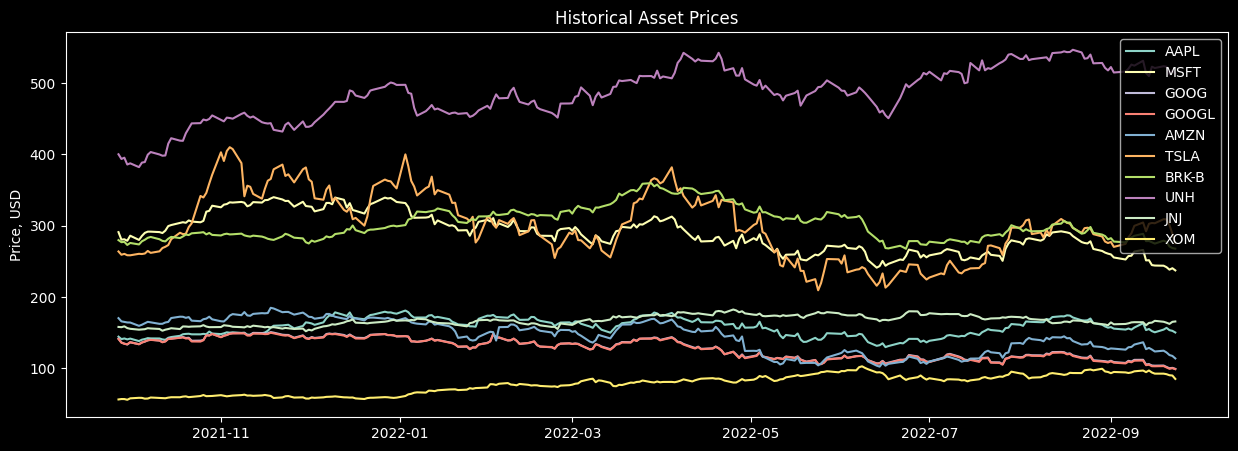

In [6]:
# Plot asset columns
MAX_TICKERS = 10

selected_prices = asset_prices.iloc[:, :MAX_TICKERS]
selected_tickers = tickers[:MAX_TICKERS]

plt.figure(figsize=(15, 5))   
plt.plot(selected_prices, 
         label=selected_tickers)

plt.title("Historical Asset Prices")
plt.ylabel("Price, USD")
plt.legend()
plt.show()

In [7]:
# Create Sharpe Dataset

sharpe_dataset = PortfolioDataset()

sharpe_dataset.load_portfolios(portfolios=portfolios,
                               asset_prices=asset_prices)

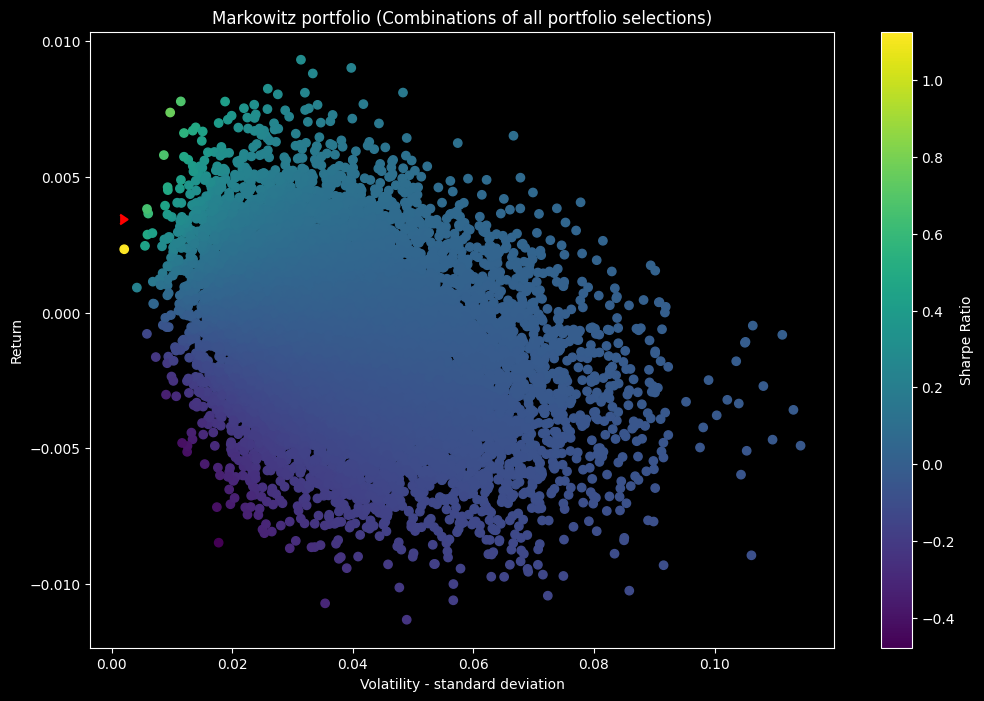

In [8]:
sharpe_dataset.plot_scatter(samples_to_plot=10000)

In [9]:
# sharpe_dataset.plot_histogram()

In [10]:
# Save Sharpe dataset

sharpe_dataset.save(DATA_FOLDER)

In [11]:
sharpe_dataset.data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,risk,return,sharpe
0,0,1,1,0,1,0,1,0,0,1,...,0,1,0,1,0,1,1,0.06594,-0.000864,-0.013102


### 2) FMQA Loop - Simulated Annealing

#### One Hot FMQA Loop

In [12]:
# FMQA Intialization

dataset = PortfolioDataset().load(DATA_FOLDER)

splitter = Splitter(dataset, batch_size=100)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

initial_dataset_sharpe = dataset.targets

total_iteration = 0

print("updated_dataset.field_dimensions:", dataset.field_dimensions.shape)

updated_dataset.field_dimensions: (30,)


Iteration 6/10
splitter.lengths: (118400, 14800, 14800)


Epoch: 1/1: 100%|███████████████████████████████████████████████████| 118k/118k [00:01<00:00, 82.2k records/s]

Train r2_score: 0.94
Test  r2_score: 0.93


new_targets.max(): 8.05
dataset.targets.max(): 8.05
initial_dataset_sharpe.max(): 1.36
Iteration 7/10
splitter.lengths: (120000, 15000, 15000)


Epoch: 1/1: 100%|███████████████████████████████████████████████████| 120k/120k [00:01<00:00, 87.6k records/s]

Train r2_score: 0.91
Test  r2_score: 0.91


new_targets.max(): 8.05
dataset.targets.max(): 8.05
initial_dataset_sharpe.max(): 1.36
Iteration 8/10
splitter.lengths: (120800, 15100, 15100)


Epoch: 1/1: 100%|███████████████████████████████████████████████████| 121k/121k [00:01<00:00, 67.7k records/s]

Train r2_score: 0.91
Test  r2_score: 0.90


new_targets.max(): 8.05
dataset.targets.max(): 8.05
initial_dataset_sharpe.max(): 1.36
Iteration 9/10
splitter.lengths: (121600, 15200, 15200)


Epoch: 1/1: 100%|███████████████████████████████████████████████████| 122k/122k [00:01<00:00, 82.8k records/s]

Train r2_score: 0.91
Test  r2_score: 0.91


new_targets.max(): 8.05
dataset.targets.max(): 8.05
initial_dataset_sharpe.max(): 1.36
Iteration 10/10
splitter.lengths: (122400, 15300, 15300)


Epoch: 1/1: 100%|███████████████████████████████████████████████████| 122k/122k [00:01<00:00, 87.6k records/s]

Train r2_score: 0.92
Test  r2_score: 0.92


new_targets.max(): 8.05
dataset.targets.max(): 8.05
initial_dataset_sharpe.max(): 1.36


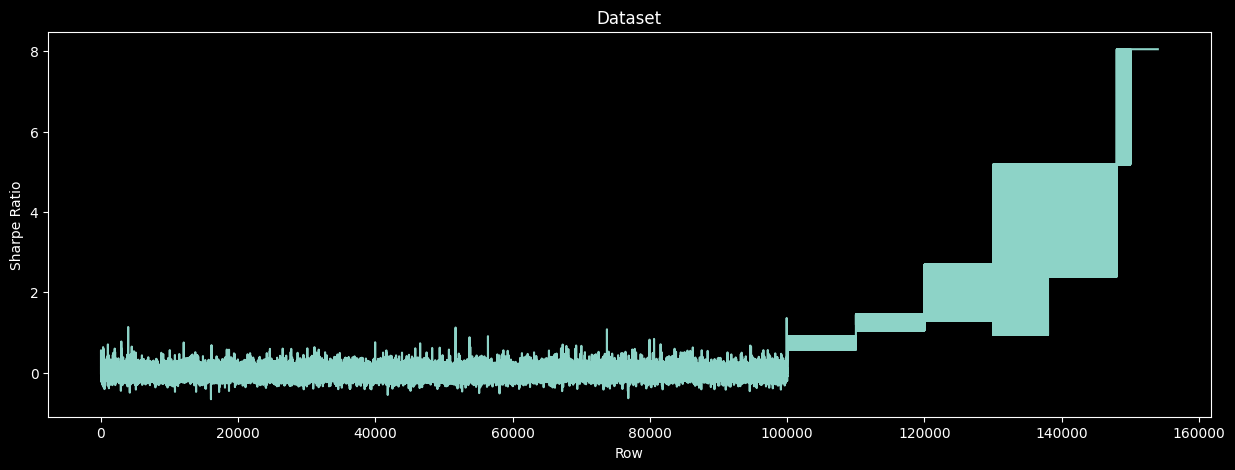

In [15]:
# FMQA Iteration

ITERATIONS_COUNT = 5

INITIAL_EPOCHS_COUNT = 1
EPOCHS_COUNT = 1
DATASET_SHARE = 1

TOP_SIZE = 10
SAMPLE_REPETITIONS_COUNT = 1000

SHOTS_COUNT = 100
PENALTY_VALUE = 10
MAXIMIZE = True

# SAMPLER = SimulatedAnnealingSampler()
# SAMPLER = ORToolsSampler()
SAMPLER = TabuSampler()
# SAMPLER = CutOffComposite(TabuSampler(), cutoff=0.01)

ORTOOLS_TIME_LIMIT = 10

total_iterations_count = total_iteration + ITERATIONS_COUNT


for iteration in range(ITERATIONS_COUNT):
    
    total_iteration += 1
    
    print(f"Iteration {total_iteration}/{total_iterations_count}")
    
    splitter = Splitter(dataset, batch_size=100,
                        dataset_share=DATASET_SHARE)
    
    print("splitter.lengths:", splitter.lengths)

    trainer = Trainer(splitter=splitter,
                      model=trainer.model,
                      optimizer=trainer.optimizer)
       
    epochs_count = INITIAL_EPOCHS_COUNT if total_iteration == 1 else EPOCHS_COUNT
    
    trainer.train(epochs=epochs_count, 
                  validate=False)

    qubo = OneHotQubo(trainer=trainer,
                      penalty_value=PENALTY_VALUE,
                      maximize=MAXIMIZE)

    sampling_results = SAMPLER.sample_qubo(Q=qubo.qubo_coefficients, 
                                           num_reads=SHOTS_COUNT,
                                           time_limit=ORTOOLS_TIME_LIMIT)
    
    aggregated_results = sampling_results.aggregate()

    filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

    results = portfolio_decode_sampling_results(filtered_results)
    
    
    # New data
    
    new_fields, new_targets = portfolio_get_top_results(results, top_size=TOP_SIZE)
    
   
    # Append to Dataset
    
    dataset.append_records(new_fields, new_targets, SAMPLE_REPETITIONS_COUNT)
    
    print(f"new_targets.max(): {new_targets.max():.02f}")
    print(f"dataset.targets.max(): {dataset.targets.max():.02f}")
    print(f"initial_dataset_sharpe.max(): {initial_dataset_sharpe.max():.02f}")        
        
plot_dataset()
# plot_samples()
# plot_top_samples()
# plot_sharpe_convergence()
# plot_dataset_histograms()

#### Top Portfolio

In [ ]:
# Load asset prices

ASSET_PRICES_PATH = 'datasets/01/asset_prices.csv'

asset_prices = pd.read_csv(ASSET_PRICES_PATH, index_col='Date')

asset_prices.index = pd.to_datetime(asset_prices.index)

tickers = asset_prices.columns.to_list()


# Top results

top_result = results.sort_values('sharpe', ascending=False).head(1)

top_portfolio = top_result.portfolio.item().astype(bool)

top_prices = asset_prices.iloc[:, top_portfolio]

top_tickers = top_prices.columns.to_numpy().squeeze()

print(f"top_sharpe: {top_result.sharpe.item():.02f}")
print("top_portfolio:", top_portfolio.astype(int))
print("top_tickers:", top_tickers)

In [ ]:
# Plot Top Portfolio

MAX_TICKERS = 10
MAX_TOP_TICKERS = 10

selected_prices = asset_prices.iloc[:, :MAX_TICKERS]
selected_tickers = tickers[:MAX_TICKERS]

if top_tickers.shape == ():    
    top_tickers = top_tickers.reshape(-1, 1)

plt.figure(figsize=(15, 5))   
plt.plot(selected_prices, 
         label=selected_tickers,
         alpha=0.7)

# plt.gca().set_prop_cycle(color='rgbcmy')
plt.gca().set_prop_cycle(color='r')

plt.plot(top_prices.iloc[:, :MAX_TOP_TICKERS], 
         label=top_tickers[:MAX_TOP_TICKERS],
         # label=top_tickers,
         linewidth=4,
         alpha=0.7)

plt.title("Top Portfolio")
plt.ylabel("Price, USD")
plt.legend()
plt.show()

### 3) FMQA Loop - Quantum Annealing on DWave device

In [ ]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

from dwave_qbsolv import QBSolv

from braket.tracking import Tracker

cost_tracker = Tracker().start()

COST_LIMIT = 10

In [ ]:
# DWave Device

dwave_2000q_arn = 'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6'
dwave_advantage_4_arn = 'arn:aws:braket:::device/qpu/d-wave/Advantage_system4'
dwave_advantage_6_arn = 'arn:aws:braket:us-west-2::device/qpu/d-wave/Advantage_system6'

dwave_arn = dwave_2000q_arn
# dwave_arn = dwave_advantage_6_arn

device = AwsDevice(dwave_arn)

print(f"device.name:", device.name)
print(f"device.properties.provider.topology:", device.properties.provider.topology)
print(f"device.properties.provider.qubitCount:", device.properties.provider.qubitCount)
print(f"len(device.properties.provider.couplers):", len(device.properties.provider.couplers))
print(f"device.properties.service.shotsRange:", device.properties.service.shotsRange)
print(f"device.properties.service.deviceLocation:", device.properties.service.deviceLocation)

In [ ]:
# DWave Samplers

dwave_sampler = BraketDWaveSampler(dwave_arn)
embedded_sampler = EmbeddingComposite(dwave_sampler)

In [ ]:
# Initialize FMQA Loop

DATA_FOLDER = 'datasets/01/'

dataset = PortfolioDataset().load(DATA_FOLDER)

# sampler = SimulatedAnnealingSampler()
sampler = TabuSampler()

splitter = Splitter(dataset, batch_size=100)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

sharpe_mins = []
sharpe_maxs = []
sharpe_means = []

initial_dataset_sharpe = dataset.targets

total_iteration = 0

print("updated_dataset.field_dimensions:", dataset.field_dimensions.shape)

In [ ]:
ITERATIONS_COUNT = 1

INITIAL_EPOCHS_COUNT = 1
EPOCHS_COUNT = 1
DATASET_SHARE = 1

TOP_SIZE = 10
SAMPLE_REPETITIONS_COUNT = 1000

SHOTS_COUNT = 1000
PENALTY_VALUE = 1
MAXIMIZE = True

REAL_DEVICE = False
# REAL_DEVICE = True

total_iterations_count = total_iteration + ITERATIONS_COUNT


for iteration in range(ITERATIONS_COUNT):
    
    current_tasks_cost = cost_tracker.qpu_tasks_cost()

    if current_tasks_cost >= COST_LIMIT:

        raise AssertionError('AWS Braket cost limit reached:', current_tasks_cost)
        
    
    total_iteration += 1
    
    print(f"Iteration {total_iteration}/{total_iterations_count}")
    
    splitter = Splitter(dataset, batch_size=100,
                        dataset_share=DATASET_SHARE)
    
    print("splitter.lengths:", splitter.lengths)

    trainer = Trainer(splitter=splitter, embedding_dimensions=16,
                      model=trainer.model,
                      optimizer=trainer.optimizer)
       
    if total_iteration == 1:
        epochs_count = INITIAL_EPOCHS_COUNT
    else:
        epochs_count = EPOCHS_COUNT
    
    trainer.fit(epochs=epochs_count, validate=False)

    qubo = PortfolioQubo(trainer=trainer,
                         penalty_value=PENALTY_VALUE,
                         maximize=MAXIMIZE)
    
    
    # Sampling
    
    chosen_sampler = embedded_sampler if REAL_DEVICE else sampler
        
    print("chosen_sampler:", chosen_sampler)
    print("Sampling...") 

    # sampling_results = chosen_sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=SHOTS_COUNT)
    
    sampling_results = QBSolv().sample_qubo(Q=qubo.qubo_coefficients,
                                            # solver='tabu',
                                            # solver=TabuSampler(),
                                            # solver=embedded_sampler,
                                            solver_limit=100, 
                                            # verbosity=1,
                                            num_reads=SHOTS_COUNT)   
        
    print("Sampling complete")    
    
    
    aggregated_results = sampling_results.aggregate()

    filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)
    
    
    # Decode

    results = []

    for sample in filtered_results.data():

        result = sample.sample

        one_hot_array = np.array(list(sample.sample.values()))    
        
        portfolio = qubo.one_hot_to_bits(one_hot_array)
        
        decimal = sum(number * 2 ** position for position, number in enumerate(reversed(portfolio)))

        result['portfolio'] = portfolio
        result['decimal'] = decimal

        result['energy'] = sample.energy
        result['num_occurrences'] = sample.num_occurrences

        results.append(result)

    results = pd.DataFrame(results)
    
    if results.shape[0] == 0:
        print("No Samples")
        continue
    
    # Real Sharpe
    
    results['risk'] = dataset.sharpe.get_risks(results.portfolio, dataset.sigma)
    results['return'] = dataset.sharpe.get_returns(results.portfolio, dataset.mu)
    
    results.risk.replace(0, 0.000001, inplace=True)

    results['sharpe'] = results['return'] / results['risk']
    
    # New data
    
    new_fields, new_targets = portfolio_get_top_results(results, top_size=TOP_SIZE)
    
    
    # Append to Dataset
    
    new_rows_count = new_fields.shape[0] * SAMPLE_REPETITIONS_COUNT
    
    new_fields_array = np.tile(new_fields, (SAMPLE_REPETITIONS_COUNT, 1))
    new_targets_array = np.tile(new_targets, (SAMPLE_REPETITIONS_COUNT, 1)).ravel()
    
    dataset.fields = np.vstack((dataset.fields, new_fields_array))
    dataset.targets = np.concatenate((dataset.targets, new_targets_array)) 
    
    
    # Sharpe Dynamics
    
    max_sharpe = new_targets.max()
    mean_sharpe = new_targets.mean()
    min_sharpe = new_targets.min()
    
    sharpe_maxs.append(max_sharpe)    
    sharpe_means.append(mean_sharpe)
    sharpe_mins.append(min_sharpe)

    print(f"new_targets.max(): {new_targets.max():.02f}")
    print(f"dataset.targets.max(): {dataset.targets.max():.02f}")
    print(f"initial_dataset_sharpe.max(): {initial_dataset_sharpe.max():.02f}")
    
    if max_sharpe == mean_sharpe == min_sharpe:
        
        print("Converged:", mean_sharpe)
        break
        
        
plot_dataset()
plot_samples()
plot_top_samples()
plot_sharpe_convergence()
plot_dataset_histograms()

### 4) Portfolio Monte-Carlo

In [ ]:
dataset = PortfolioDataset()
dataset.load(DATA_FOLDER)

initial_dataset_sharpe = dataset.targets

sharpe_mins = []
sharpe_maxs = []
sharpe_means = []

total_iteration = 0

In [ ]:
ITERATIONS_COUNT = 1
MC_SAMPLES_COUNT = 1000000

TOP_SIZE = 10
SAMPLE_REPETITIONS_COUNT = 1000

ASSETS_COUNT = dataset.fields.shape[1]

total_iterations_count = total_iteration + ITERATIONS_COUNT


for iteration in range(ITERATIONS_COUNT):
    
    total_iteration += 1
    
    print(f"Iteration {total_iteration}/{total_iterations_count}")
    
    portfolios = np.random.randint(0, 2, size=(MC_SAMPLES_COUNT, ASSETS_COUNT))
    
    results = pd.DataFrame(portfolios)
    
    results['sharpe'] = dataset.sharpe.get_sharpe(portfolios, dataset.sigma, dataset.mu)
    
    top_results = results.sort_values('sharpe', ascending=False)[:TOP_SIZE]

    new_fields = top_results.iloc[:, :ASSETS_COUNT]

    new_targets = top_results.sharpe.to_numpy()
       
    
    # Append to Dataset
    
    new_rows_count = new_fields.shape[0] * SAMPLE_REPETITIONS_COUNT
    
    new_fields_array = np.tile(new_fields, (SAMPLE_REPETITIONS_COUNT, 1))
    new_targets_array = np.tile(new_targets, (SAMPLE_REPETITIONS_COUNT, 1)).ravel()
    
    dataset.fields = np.vstack((dataset.fields, new_fields_array))
    dataset.targets = np.concatenate((dataset.targets, new_targets_array)) 
    
    
    # Sharpe Dynamics
    
    max_sharpe = new_targets.max()
    mean_sharpe = new_targets.mean()
    min_sharpe = new_targets.min()
    
    sharpe_maxs.append(max_sharpe)    
    sharpe_means.append(mean_sharpe)
    sharpe_mins.append(min_sharpe)

    print(f"new_targets.max(): {new_targets.max():.02f}")
    print(f"dataset.targets.max(): {dataset.targets.max():.02f}")
    print(f"initial_dataset_sharpe.max(): {initial_dataset_sharpe.max():.02f}")
    
    if max_sharpe == mean_sharpe == min_sharpe:
        
        print("Converged:", mean_sharpe)
        break
        

plt.figure(figsize=(15, 5))
plt.title("Dataset")
plt.xlabel("Row")
plt.ylabel("Sharpe Ratio")

plt.plot(dataset.targets,
         # color='C7',
         color='grey')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(sharpe_maxs, label="Sharpe Ratio Maximum")
plt.plot(sharpe_means, label="Sharpe Ratio Mean")
plt.plot(sharpe_mins, label="Sharpe Ratio Minimum")

plt.title("Sharpe Ratio Convergence")
plt.xlabel("Iteration")
plt.ylabel("Sharpe Ratio")

plt.legend()
plt.show()

### 2) Standalone FMQA

#### FM

In [ ]:
DATA_FOLDER = 'datasets/01/'

dataset = PortfolioDataset().load(DATA_FOLDER)

splitter = Splitter(dataset, batch_size=100)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

print("dataset.field_dimensions:", dataset.field_dimensions)
# print(dataset.data.head())
# dataset.plot_scatter()
print("Splitter lengths:", splitter.lengths) 

In [ ]:
trainer.train(epochs=3, validate=False)

In [ ]:
# Predict

INDEX_STEP = 1000

indices = np.arange(0, len(dataset), INDEX_STEP)

fields = splitter.dataset.fields[indices]
targets = splitter.dataset.targets[indices]

predictions = trainer.predict(fields)

r2_score = sklearn.metrics.r2_score(targets, predictions)

# Plot

plt.figure(figsize=(15, 5))

plt.plot(targets, label=f"Sharpe Ratio - Targets")
plt.plot(predictions, label=f"Sharpe Ratio - Predictions - R2 score {r2_score:.02f}")

plt.locator_params(axis='x', nbins=20)

plt.title("Predictions")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

plt.show()

#### QUBO

In [ ]:
PENALTY_VALUE = 1

MAXIMIZE = True

SHOTS_COUNT = 1000

qubo = OneHotQubo(trainer=trainer,
                  penalty_value=PENALTY_VALUE,
                  maximize=MAXIMIZE)

In [ ]:
# QUBO Energies

INDEX_STEP = 1000

indices = np.arange(0, len(dataset), INDEX_STEP)


# Energies

bqm = dimod.BinaryQuadraticModel.from_qubo(qubo.qubo_coefficients)

quadratic = bqm.quadratic
linear = bqm.linear
offset = bqm.offset

energies = []
bqm_energies = []


for row_bits in dataset.fields[indices]:
    
    one_hot_row = qubo.bits_to_one_hot(row_bits)

    sample = dict(enumerate(one_hot_row))

    energy = dimod.utilities.qubo_energy(sample=sample, Q=qubo.qubo_coefficients)
        
    bqm_energy = dimod.utilities.ising_energy(sample=sample, J=quadratic, h=linear, offset=offset)
    
    energies.append(energy)
    bqm_energies.append(bqm_energy)

    
# Predictions

fields = splitter.dataset.fields[indices]
targets = splitter.dataset.targets[indices]

predictions = trainer.predict(fields)


# General Plot

figure, data_ax = plt.subplots(figsize=(15, 5))
energy_ax = data_ax.twinx()

data_ax.plot(indices, targets, label="Target Sharpe Ratio")
data_ax.plot(indices, predictions, label="Predicited Sharpe Ratio", color='#fdb462')
energy_ax.plot(indices, energies, label="QUBO Energy", color='#fa8174', alpha=0.5)
# energy_ax.plot(indices, bqm_energies, label="BQM Energy", color='r')

energy_ax.invert_yaxis()

plt.title('Sharpe Ratios and corresponding Energies')
data_ax.set_xlabel("Portfolio")
data_ax.set_ylabel("Sharpe Ratio")
energy_ax.set_xlabel("Portfolio")
energy_ax.set_ylabel("QUBO Energy")

figure.legend(bbox_to_anchor=(0.895, 0.87))

plt.show()

#### Simulated Annealing

In [ ]:
sampler = SimulatedAnnealingSampler()

# new_bqm = dimod.BinaryQuadraticModel(bqm.linear,
#                                      bqm.quadratic,
#                                      bqm.offset,
#                                      vartype=dimod.BINARY)

# spin_bqm = new_bqm.change_vartype(dimod.SPIN, inplace=False)


sampling_results = sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=SHOTS_COUNT)

# sampling_results = sampler.sample_qubo(Q=range_qubo_coefficients, num_reads=shots_count)

# sampling_results = sampler.sample_qubo(Q=excluded_qubo_coefficients, num_reads=shots_count)


# sampling_results = sampler.sample_ising(J=bqm.quadratic, h=bqm.linear, num_reads=shots_count)

# new_linear = {k[0]: v for k, v in qubo.qubo_coefficients.items() if k[0] == k[1]}

# sampling_results = sampler.sample_ising(J=qubo.qubo_coefficients, h=new_linear, num_reads=shots_count)

# sampling_results = sampler.sample(bqm=spin_bqm, num_reads=shots_count)

In [ ]:
aggregated_results = sampling_results.aggregate()

filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

print("sampling_results:", len(sampling_results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

In [ ]:
# Decode

decoded_results = []

for sample in filtered_results.data():
    
    result = sample.sample
    
    one_hot_array = np.array(list(sample.sample.values()))
    portfolio = qubo.one_hot_to_bits(one_hot_array)
    decimal = sum(number * 2 ** position for position, number in enumerate(reversed(portfolio)))
    
    result['portfolio'] = portfolio
    result['decimal'] = decimal
    
    result['energy'] = sample.energy
    result['num_occurrences'] = sample.num_occurrences
    
    decoded_results.append(result)
    
decoded_results = pd.DataFrame(decoded_results)

# pd.set_option('display.max_rows', 10)

# print("maximize:\n", MAXIMIZE)
# print("decoded_results.head:\n", decoded_results.head())

In [ ]:
# Plot Samples

results = decoded_results.sort_values('decimal')

portfolios = results['portfolio'].to_numpy()
decimals = results['decimal'].to_numpy()
energies = results['energy'].to_numpy()
sizes = results['num_occurrences'].to_numpy()
    
sizes = sizes - min(sizes)
sizes = sizes ** 10
sizes = sizes / (max(sizes) or 1) * 100 
sizes[sizes < 1] = 1

plt.figure(figsize=(15, 5))

plt.plot(decimals, energies, 
         color='C5', 
         # color='C1', 
         alpha=0.5)

plt.scatter(decimals, energies,
            label=f"Occurrences",
            color='#fdb462',
            # color='C1', 
            s=sizes + 1)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Annealing Samples")
plt.xlabel("Portfolio")
plt.ylabel("Energy")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Sharpe Ratio Predictions for samples

trainer.model.eval()

portfolios_array = np.stack(results.portfolio).astype(int)

with torch.no_grad():

    predictions_for_samples = trainer.model(torch.tensor(portfolios_array))

predictions_for_samples

results['prediction'] = predictions_for_samples

In [ ]:
# Real Sharpe Ratios for Samples

INDEX_STEP = 1

sharpes_for_samples = dataset.sharpe.get_sharpe(results.portfolio, dataset.sigma, dataset.mu)

results['sharpe'] = sharpes_for_samples

plt.figure(figsize=(15, 5))

plt.scatter(x=results.decimal[::INDEX_STEP], 
            y=results.sharpe[::INDEX_STEP],
            c=results.sharpe[::INDEX_STEP],
            label="Real Sharpe Ratio",
            s=20)

# plt.plot(results.decimal[::INDEX_STEP], results.sharpe[::INDEX_STEP], color='indigo', alpha=0.5)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Real Sharpe Ratios for Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Predicted Sharpe Ratios for Samples

INDEX_STEP = 1

sharpes_for_samples = dataset.sharpe.get_sharpe(results.portfolio, dataset.sigma, dataset.mu)

results['sharpe'] = sharpes_for_samples

plt.figure(figsize=(15, 5))

plt.scatter(x=results.decimal[::INDEX_STEP], 
            y=results.prediction[::INDEX_STEP],
            c=results.prediction[::INDEX_STEP],
            label="Predicted Sharpe Ratio",
            s=20)

# plt.plot(results.decimal[::INDEX_STEP], results.prediction[::INDEX_STEP], color='indigo', alpha=0.5)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Predicted Sharpe Ratios for Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Real and Predicted Sharpe Ratios for Samples

INDEX_STEP = 10

sharpes_for_samples = dataset.sharpe.get_sharpe(results.portfolio, dataset.sigma, dataset.mu)

results['sharpe'] = sharpes_for_samples

plt.figure(figsize=(15, 5))

plt.plot(results.decimal[::INDEX_STEP], results.sharpe[::INDEX_STEP], color='indigo',
         label="Real Sharpe Ratio")
plt.plot(results.decimal[::INDEX_STEP], results.prediction[::INDEX_STEP], color='C3',
         label="Predicted Sharpe Ratio")

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Real and Predicted Sharpe Ratios for Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Dataset Sharpe Ratios

INDEX_STEP = 10

plt.subplots(figsize=(15, 5))

plt.scatter(x=dataset.data.index[::INDEX_STEP],
            y=dataset.data.sharpe[::INDEX_STEP],
            c=dataset.data.sharpe[::INDEX_STEP], 
            s=20)

# plt.plot(results.decimal, results.energy, color='indigo', alpha=0.5)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Dataset - Real Sharpe Ratios")
plt.xlabel("Portfolio")
plt.ylabel("Energy")

# plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Top Sharpes by Energy and by Sharpe

FIRST_PART = 100

results_by_energy = results.sort_values('energy', ascending=True)
results_by_sharpe = results.sort_values('sharpe', ascending=False)

plt.figure(figsize=(15, 5))
plt.plot(results_by_energy.index[:FIRST_PART], results_by_energy.sharpe[:FIRST_PART], label='Top by energy', c='C5')
plt.plot(results_by_energy.index[:FIRST_PART], results_by_sharpe.sharpe[:FIRST_PART], label='Top by Sharpe')

plt.title(f"Top Energies and Sharpe ratios of top {FIRST_PART} samples")
plt.xlabel("Sample")
plt.ylabel("Sharpe Ratio")

plt.legend()
plt.show()

#### Quantum Annealing - Run on DWave device

In [ ]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

from braket.tracking import Tracker

cost_tracker = Tracker().start()

COST_LIMIT = 1

In [ ]:
# D-Wave 2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")

# # D-Wave Advantage device
# device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")

print(f"device.name:", device.name)
print(f"device.properties.provider.topology:", device.properties.provider.topology)
print(f"device.properties.provider.qubitCount:", device.properties.provider.qubitCount)
print(f"len(device.properties.provider.couplers):", len(device.properties.provider.couplers))
print(f"device.properties.service.shotsRange:", device.properties.service.shotsRange)
print(f"device.properties.service.deviceLocation:", device.properties.service.deviceLocation)

In [ ]:
qubo.coupling_matrix.shape

In [ ]:
dwave_2000q_sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
embedded_sampler = EmbeddingComposite(dwave_2000q_sampler)

In [ ]:
num_reads = 1000

# if cost_tracker.qpu_tasks_cost() < COST_LIMIT:

    # sampling_results = embedded_sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=num_reads)

In [ ]:
print("quantum_tasks_statistics:", cost_tracker.quantum_tasks_statistics())
print("qpu_tasks_cost:", cost_tracker.qpu_tasks_cost())
print("simulator_tasks_cost:", cost_tracker.simulator_tasks_cost())

In [ ]:
# # Save results

# RESULTS_FILENAME = 'quantum_annealing_results/2000q_60_qubits_trained.npy'

# np.save(RESULTS_FILENAME, sampling_results)

In [ ]:
# Load results

RESULTS_FILENAME = 'quantum_annealing_results/2000q_60_qubits_trained.npy'

sampling_results = np.load(RESULTS_FILENAME, allow_pickle=True).item()

In [ ]:
aggregated_results = sampling_results.aggregate()

filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

print("sampling_results:", len(sampling_results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

# print("sampling_results:\n", sampling_results)
# print("aggregated_results:\n", aggregated_results)
# print("filtered_results:\n", filtered_results)

In [ ]:
# Decode

decoded_results = []

for sample in filtered_results.data():
    
    result = sample.sample
    
    one_hot_array = np.array(list(sample.sample.values()))
    portfolio = qubo.one_hot_to_bits(one_hot_array)
    decimal = sum(number * 2 ** position for position, number in enumerate(reversed(portfolio)))
    
    result['portfolio'] = portfolio
    result['decimal'] = decimal
    
    result['energy'] = sample.energy
    result['num_occurrences'] = sample.num_occurrences
    
    decoded_results.append(result)
    
decoded_results = pd.DataFrame(decoded_results)

In [ ]:
# Plot Samples

results = decoded_results.sort_values('decimal')

portfolios = results['portfolio'].to_numpy()
decimals = results['decimal'].to_numpy()
energies = results['energy'].to_numpy()
sizes = results['num_occurrences'].to_numpy()
    
sizes = sizes - min(sizes)
sizes = sizes ** 10
sizes = sizes / (max(sizes) or 1) * 100 
sizes[sizes < 1] = 1

plt.figure(figsize=(15, 5))

plt.plot(decimals, energies, color='C3', alpha=0.5)

plt.scatter(decimals, energies,
            label=f"Occurrences",
            color='#fdb462',
            s=sizes + 1)

plt.ticklabel_format(style='plain', useOffset=False)

plt.title("Annealing Samples")
plt.xlabel("Portfolio")
plt.ylabel("Energy")
plt.legend()

# plt.gca().invert_yaxis()

plt.show()

### 3) Embeddings and QUBO

#### Minor Embedding

In [ ]:
# DWave 2000Q Embedding

from braket.ocean_plugin import BraketDWaveSampler


dwave_2000q_sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')

target_nodelist, target_edgelist, target_adjacency = dwave_2000q_sampler.structure

dwave_2000q_embedding = find_embedding(qubo.qubo_coefficients, target_edgelist, verbose=1, interactive=True)

In [ ]:
# Chimera Graph Embedding

import dwave_networkx as dnx
import networkx as nx

one_chimera_graph = dnx.chimera_graph(2, 2, 4)

one_chimera_layout = dnx.chimera_layout(one_chimera_graph)

In [ ]:
nx.draw(one_chimera_graph, pos=one_chimera_layout)

In [ ]:
from minorminer import find_embedding

chimera_graph = dnx.chimera_graph(16, 16, 4)

chimera_embedding = find_embedding(qubo.qubo_coefficients, chimera_graph.edges, verbose=1, interactive=True)

In [ ]:
structured_sampler = dimod.StructureComposite(TabuSampler(),
                                              chimera_graph.nodes,
                                              chimera_graph.edges)

In [ ]:
from dwave.system.composites import FixedEmbeddingComposite

embedded_sampler = FixedEmbeddingComposite(structured_sampler, embedding=chimera_embedding)

In [ ]:
sampling_results = embedded_sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=100)

In [ ]:
print(sampling_results)

#### QUBO Functions

In [ ]:
# https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/generators.html

In [ ]:
# 1) Combinations

bqm = dimod.generators.combinations(3, 1, strength=10, vartype='BINARY')

bqm

In [ ]:
print(dimod.ExactSolver().sample(bqm).lowest())
print()
print(dimod.ExactSolver().sample(bqm))

In [ ]:
# 2) Binary Encoding

bqm = dimod.generators.binary_encoding(v='i', upper_bound=7) + 4

bqm

In [ ]:
bqm.to_qubo()

In [ ]:
print(dimod.ExactSolver().sample(bqm).lowest())
print()
print(dimod.ExactSolver().sample(bqm))

In [ ]:
sample = {('i', 1): 0, ('i', 2): 1, ('i', 4, 'msb'): 1}

bqm.energy(sample)

In [ ]:
sum(v[1]*val for v, val in sample.items()) + bqm.offset

In [ ]:
# 3) Full Adder

bqm = dimod.generators.fulladder_gate('a1', 'a2', 'a3', 's', 'c')

print(dimod.ExactSolver().sample(bqm).lowest())

In [ ]:
# 5) Multiplication

# https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/generated/dimod.generators.multiplication_circuit.html#dimod.generators.multiplication_circuit


bqm = dimod.generators.multiplication_circuit(num_arg1_bits=2,
                                              num_arg2_bits=2)

for fixed_var, fixed_val in {'a0': 0, 'a1': 1, 'b0':1, 'b1': 1}.items():
    
    bqm.fix_variable(fixed_var, fixed_val)

best = TabuSampler().sample(bqm).first

p = {key: best.sample[key] for key in best.sample.keys() if "p" in key}

print(p)

In [ ]:
print(dimod.ExactSolver().sample(bqm).lowest())
print()
print(dimod.ExactSolver().sample(bqm))

### 5) Samplers

#### QBSolv

In [ ]:
from dwave_qbsolv import QBSolv

In [ ]:
# from hybrid.reference.qbsolv import SimplifiedQbsolv

In [ ]:
Q = {(0, 0): 1, (1, 1): 1, (0, 1): 1}

In [ ]:
# sampler = SimulatedAnnealingSampler()
sampler = TabuSampler()

In [ ]:
Q = qubo.qubo_coefficients

response = QBSolv().sample_qubo(Q, solver=sampler,
                                solver_limit=1000, verbosity=1)

# print("samples=" + str(list(response.samples())))
# print("energies=" + str(list(response.data_vectors['energy'])))

#### 5 Composite Samplers

In [ ]:
# https://support.dwavesys.com/hc/en-us/community/posts/360052899913-dwave-hybrid-vs-qbsolv-really-which-works-best-

In [ ]:
# 1) QBSolv

QBSolv_iter = 50
#sampler = neal.SimulatedAnnealingSampler()
time_start = time.time()
QBSolv_response = QBSolv().sample_qubo(Q, num_repeats=QBSolv_iter) # solving with default tabu search

response = QBSolv().sample_qubo(Q, solver=sampler)

#response = QBSolv().sample_qubo(Q, solver=sampler, solver_limit=subqubo_size)

time_stop = time.time()

CPUtime_QBSolv = time_stop - time_start

print('CPU time QBSolv: {}'.format(CPUtime_QBSolv))
print('Minimum energy QBSolv: {}'.format(QBSolv_response.data_vectors['energy'][0]))

In [ ]:
# 2) Hybrid-SA-TSearch

model = dimod.BinaryQuadraticModel.from_qubo(Q)

# construct a workflow that races Simulated Annealing against SA/Tabu on a subproblem

iteration = hybrid.Race(
    hybrid.SimulatedAnnealingProblemSampler(),
    hybrid.EnergyImpactDecomposer(size=50)
    | hybrid.RacingBranches(
        hybrid.SimulatedAnnealingSubproblemSampler(num_sweeps=1000),
        hybrid.TabuSubproblemSampler(tenure=20, timeout=10))
    | hybrid.ArgMin('subsamples.first.energy')
    | hybrid.SplatComposer()
) | hybrid.ArgMin('samples.first.energy')

main = hybrid.Loop(iteration, max_iter=2, convergence=3)

In [ ]:
# run the workflow

time_start = time.time()

init_state = hybrid.State.from_sample(hybrid.utils.min_sample(model), model)

Hybrid_SA_TS_response = main.run(init_state).result()

time_stop=time.time()

CPUtime_Hybrid_SA_TS = time_stop - time_start

print('CPU time Hybrid_SA_TS: {}'.format(CPUtime_Hybrid_SA_TS))
print('Minimum energy Hybrid_SA_TS: {}'.format(Hybrid_SA_TS_response.samples.first.energy))

In [ ]:
# 3) Hybrid-Dialectic-Search

# construct a Dialectic Search workflow

generate_antithesis = (
    hybrid.IdentityDecomposer()
    | hybrid.RandomSubproblemSampler()
    | hybrid.SplatComposer()
    | hybrid.TabuProblemSampler()
)

generate_synthesis = (
    hybrid.GreedyPathMerge()
    | hybrid.TabuProblemSampler()
)

tracker = hybrid.TrackMin()

local_update = hybrid.LoopWhileNoImprovement(
    hybrid.Parallel(hybrid.Identity(), generate_antithesis)
    | generate_synthesis 
    | tracker, 
    max_tries=10
)

global_update = hybrid.Loop(
    generate_antithesis 
    | local_update, 
    max_iter=1
)

In [ ]:
# run the workflow

time_start = time.time()

init_state = hybrid.State.from_sample(hybrid.min_sample(model), model)

final_state = global_update.run(init_state).result()

Hybrid_Dialectic_response = tracker.best

time_stop = time.time()

CPUtime_Hybrid_Dialectic = time_stop - time_start

print('CPU time Hybrid_Dialectic: {}'.format(CPUtime_Hybrid_Dialectic))
print('Minimum energy Hybrid_Dialectic: {}'.format(Hybrid_Dialectic_response.samples.first.energy))

In [ ]:
# 4) Hybrid-QBSolv-like

# define the QBSolv-like workflow

iteration = hybrid.Race(
    hybrid.InterruptableTabuSampler(),
    hybrid.EnergyImpactDecomposer(size=50, rolling=True, rolling_history=0.15)
    #| hybrid.QPUSubproblemAutoEmbeddingSampler()
    | hybrid.TabuSubproblemSampler()#(timeout=10)
    | hybrid.SplatComposer()
) | hybrid.ArgMin() | hybrid.TrackMin(output=True)

main = hybrid.Loop(iteration, max_iter=50, convergence=3)

In [ ]:
# run the workflow

time_start = time.time()

init_state = hybrid.State.from_sample(hybrid.min_sample(model), model)

Hybrid_QBSolv_like_response = main.run(init_state).result()

time_stop = time.time()

CPUtime_Hybrid_QBSolv_like = time_stop - time_start

print('CPU time Hybrid_QBSolv_like: {}'.format(CPUtime_Hybrid_QBSolv_like))
print('Minimum energy Hybrid_QBSolv_like: {}'.format(Hybrid_QBSolv_like_response.samples.first.energy))

In [ ]:
# 5) Parallel tempering workflow

import neal

# from hybrid.reference.pt import FixedTemperatureSampler
# from hybrid.reference.pt import SwapReplicaPairRandom

n_sweeps = 10000
n_replicas = 10
n_random_swaps = n_replicas - 1
n_iterations = 10

# replicas are initialized with random samples

# bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(Q)

bqm = model

state = hybrid.State.from_problem(bqm)

replicas = hybrid.States(*[state.updated() for _ in range(n_replicas)])


# get a reasonable beta range

beta_hot, beta_cold = neal.default_beta_range(bqm)


# generate betas for all branches/replicas

betas = np.geomspace(beta_hot, beta_cold, n_replicas)

In [ ]:
# run replicas update/swap for n_iterations

# (after each update/sampling step, do n_replicas-1 random adjacent pair swaps)

update = hybrid.Branches(*[
    hybrid.reference.pt.FixedTemperatureSampler(beta=beta, num_sweeps=n_sweeps) 
    for beta in betas])

swap = hybrid.Loop(hybrid.reference.pt.SwapReplicaPairRandom(betas=betas), 
                   max_iter=n_random_swaps)

workflow = hybrid.Loop(
    update 
    | swap, 
    max_iter=n_iterations) \
| hybrid.MergeSamples(aggregate=True)

time_start = time.time()

Par_Tempering_response = workflow.run(replicas).result()

time_stop = time.time()

CPUtime_Par_Tempering = time_stop - time_start

print('CPU time Hybrid_Par_Tempering: {}'.format(CPUtime_Par_Tempering))
print('Minimum energy Hybrid_Par_Tempering: {}'.format(Par_Tempering_response.samples.first.energy))  

#### Kerberos

In [ ]:
response = hybrid.KerberosSampler().sample_ising({'a': -0.5, 'b': 1.0}, {('a', 'b'): -1}, 
                                                 qpu_sampler=SimulatedAnnealingSampler())

response.data_vectors['energy']

### DWave 2000Q - Minimal Example

In [ ]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

import dimod

In [ ]:
from braket.tracking import Tracker

cost_tracker = Tracker().start()

COST_LIMIT = 1

In [ ]:
# D-Wave 2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")

# # D-Wave Advantage device
# device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")

print(f"device.name:", device.name)
print(f"device.properties.provider.topology:", device.properties.provider.topology)
print(f"device.properties.provider.qubitCount:", device.properties.provider.qubitCount)
print(f"len(device.properties.provider.couplers):", len(device.properties.provider.couplers))
print(f"device.properties.service.shotsRange:", device.properties.service.shotsRange)
print(f"device.properties.service.deviceLocation:", device.properties.service.deviceLocation)

In [ ]:
# Example model

num_reads = 100

vartype = dimod.SPIN
# vartype = dimod.BINARY

quadratic = {(0, 1): 1.0, (0,4): 2.0, (1, 2): 1.0, (1,4): 1.0, (2, 3): 1.0, (3, 4): 1.0}
linear = {0: +1.0}
offset = 0.0

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

In [ ]:
sampler = dimod.SimulatedAnnealingSampler()

response = sampler.sample(model, num_reads=num_reads)

response_aggregate = response.aggregate()
print(response_aggregate)

In [ ]:
# Real device

sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
embedded_sampler = EmbeddingComposite(sampler)

In [ ]:
# if cost_tracker.qpu_tasks_cost() < COST_LIMIT:    

#     response = embedded_sampler.sample(model, num_reads=num_reads)

In [ ]:
print(response)

In [ ]:
print("quantum_tasks_statistics:", cost_tracker.quantum_tasks_statistics())
print("qpu_tasks_cost:", cost_tracker.qpu_tasks_cost())
print("simulator_tasks_cost:", cost_tracker.simulator_tasks_cost())

### Experiments

#### Simple MC Loop

In [ ]:
# Simple MC Loop

ITERATIONS_COUNT = 10
MC_SAMPLES_COUNT = 100000

mc_max_sharpes = []
mc_max_portfolios = []

iteration = 0

while iteration < ITERATIONS_COUNT:
    
    iteration += 1

    mc_portfolios = np.random.randint(0, 2, size=(MC_SAMPLES_COUNT, ASSETS_COUNT))
    
    mc_sharpe = get_sharpe(mc_portfolios, sigma, mu)
    
    mc_max_sharpe_index = mc_sharpe.argmax()
    
    mc_max_sharpe = mc_sharpe[mc_max_sharpe_index]

    mc_max_portfolio = mc_portfolios[mc_max_sharpe_index]
    
    mc_max_sharpes.append(mc_max_sharpe)
    mc_max_portfolios.append(mc_max_portfolio)
    
    if not iteration % 1: 
    
        print("iteration:", iteration)
        print("max(mc_max_sharpes):", max(mc_max_sharpes))

#### Statistical values

In [ ]:
# Statistical values

means = data.get_mean_vector()
rho = data.get_similarity_matrix()
cov = data.get_covariance_matrix()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


# print("Means:\n", means)

# print("A time-series similarity measure:")
# plt.imshow(rho)
# plt.show()

# print("A covariance matrix:")
# plt.imshow(cov)
# plt.show()


# print("Sigma:")
# # plt.imshow(sigma, interpolation='nearest')
# plt.show()

# print("Mu:", mu)

#### Multiindex

In [ ]:
sections = ['portfolio']
parameters = range(4)
multiindex = pd.MultiIndex.from_product([sections, parameters],
                                        names=['sections', 'parameters'])

df = pd.DataFrame(columns=multiindex)

df['portfolio'] = (0, 1, 1, 2)

S_PATH = 'datasets/s.csv'

df.to_csv(S_PATH)

loaded_df = pd.read_csv(S_PATH, header=[0, 1], index_col=0)

loaded_df

#### Plots

In [ ]:
# Monte-Carlo generated Sharpe Ratios

INDEX_STEP = 1

sorted_sharpe_dataset = sharpe_dataset[::INDEX_STEP].sort_values('sharpe', ignore_index=True)

plt.figure(figsize=(15, 5))

plt.scatter(x=sorted_sharpe_dataset.index, 
            y=sorted_sharpe_dataset.sharpe, 
            c=sorted_sharpe_dataset.sharpe,
            label="Sharpe Ratios",
            s=1)

plt.title("Monte-Carlo generated Sharpe Ratios")
plt.xlabel("Portfolio Excellence")
plt.ylabel("Sharpe Ratio")
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [ ]:
# PART = 100

# plt.plot(indices[:PART], targets[:PART], label="Target Sharpe Ratio")
# plt.xlabel("Portfolio")
# plt.ylabel("Sharpe Ratio")
# plt.legend()
# plt.show()

# plt.plot(indices[:PART], predictions[:PART], label="Predicited Sharpe Ratio", color='#fdb462')
# plt.xlabel("Portfolio")
# plt.ylabel("Sharpe Ratio")
# plt.legend()
# plt.show()

# plt.plot(indices[:PART], energies[:PART], label="QUBO Energy", color='#fa8174')
# plt.xlabel("energy")
# plt.ylabel("Sharpe Ratio")
# plt.legend()
# plt.show()

In [ ]:
# Sampled Sharpe Ratios

INDEX_STEP = 10


dataset_by_sharpe = dataset.data.sort_values('sharpe', ignore_index=True)

samples_in_dataset = dataset_by_sharpe[dataset_by_sharpe.decimal.isin(results.decimal)]


plt.figure(figsize=(15, 5))

plt.scatter(x=dataset_by_sharpe.index[::INDEX_STEP], 
            y=dataset_by_sharpe.sharpe[::INDEX_STEP], 
            c=dataset_by_sharpe.sharpe[::INDEX_STEP], 
            s=1)

plt.scatter(samples_in_dataset.index, 
            samples_in_dataset.sharpe,
            c='C5', s=100,
            label="Sampled Sharpe Ratios")

plt.title("Sampled Sharpe Ratios")
plt.xlabel("Portfolio Excellence")
plt.ylabel("Sharpe Ratio")

plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [ ]:
# Sharpe Ratios for Monte-Carlo and Annealer Samples

INDEX_STEP = 1

RATIO = dataset.data.shape[0] // results.shape[0]


dataset_by_sharpe = dataset.data.sort_values('sharpe', ignore_index=True)

samples_in_dataset = dataset_by_sharpe[dataset_by_sharpe.decimal.isin(results.decimal)]


results_by_prediction = results.sort_values('prediction', ignore_index=True)


plt.figure(figsize=(15, 5))

plt.scatter(x=dataset_by_sharpe.index[::INDEX_STEP * RATIO], 
            y=dataset_by_sharpe.sharpe[::INDEX_STEP * RATIO], 
            c=dataset_by_sharpe.sharpe[::INDEX_STEP * RATIO], 
            label="Monte-Carlo",
            cmap='viridis',
            s=5)

# plt.scatter(x=dataset_by_sharpe.index[::INDEX_STEP * RATIO], 
#             y=results_by_prediction.prediction[::INDEX_STEP], 
#             c=results_by_prediction.prediction[::INDEX_STEP],
#             label="Annealer Samples",
#             cmap='inferno',
#             s=5)

plt.ticklabel_format(style='plain')

plt.title("Sharpe Ratios distribution for Monte-Carlo and Annealer Samples")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")

plt.legend(markerscale=5, scatterpoints=100)
plt.show()

#### Matrics

In [ ]:
factorization_matrix = np.random.randint(0, 10, size=(3, 6))

factorization_matrix

In [ ]:
coupling_matrix = factorization_matrix @ factorization_matrix.T

coupling_matrix

In [ ]:
qubo_dict = qubo.get_coupling_coefficients(coupling_matrix)

qubo_dict

In [ ]:
sample = [1, 1, 1]

energy = 0
energy_alt = 0

for i, j in qubo_dict:
    
    energy += sample[i] * sample[j] * qubo_dict[(i, j)]
    
    energy_alt += sample[i] * sample[j] * np.dot(factorization_matrix[i], 
                                                 factorization_matrix[j])
    
energy, energy_alt

In [ ]:
### QUBO replacement

# qubo.qubo_coefficients

In [ ]:
new_qubo_coefficients = {(i, j): coefficient 
                         for (i, j), coefficient 
                         in qubo.qubo_coefficients.items()
                         if i != j}

# new_qubo_coefficients

In [ ]:
qubo.qubo_coefficients = new_qubo_coefficients

In [ ]:
# Manual Energies

import dimod


qubo_coefficients = qubo.qubo_coefficients

portfolio = [0, 0, 0, 0, 0, 0, 0, 1] 
    
sample = qubo.bits_to_one_hot(portfolio)

energy_from_coupling_matrix = 0
energy_from_factorization_matrix = 0

for i, j in qubo_coefficients:
    
    energy_from_coupling_matrix += sample[i] * sample[j] * qubo_coefficients[(i, j)]
    
    energy_from_factorization_matrix += sample[i] * sample[j] * np.dot(qubo.factorization_matrix[i], 
                                                                       qubo.factorization_matrix[j])


sample_dict = dict(enumerate(sample))

dimod_energy = dimod.utilities.qubo_energy(sample=sample_dict, Q=qubo_coefficients)

print("portfolio:", portfolio)
print("sample:", sample)

print("dimod_energy:", dimod_energy)
print("energy_from_coupling_matrix:", energy_from_coupling_matrix)
print("energy_from_factorization_matrix:", energy_from_factorization_matrix)

In [ ]:
state_dict = trainer.model.state_dict()

factorization_matrix = state_dict['embedding.embedding.weight'].numpy().squeeze()

factorization_matrix[:4]

In [ ]:
# Prediction - FM Model

PORTFOLIO_INDEX = 1

encoded_fields = trainer.splitter.dataset.fields[PORTFOLIO_INDEX]
targets = trainer.splitter.dataset.targets[PORTFOLIO_INDEX]

trainer.model.eval()

with torch.no_grad():

    predictions = trainer.model(torch.tensor(encoded_fields))

encoded_fields, targets, predictions

In [ ]:
fields = splitter.dataset.fields[PORTFOLIO_INDEX]
targets = splitter.dataset.targets[PORTFOLIO_INDEX]

trainer.predict(fields)

In [ ]:
# Prediction - FM Model Disassembled

PORTFOLIO_INDEX = 1

encoded_fields = trainer.splitter.dataset.fields[PORTFOLIO_INDEX]
targets = trainer.splitter.dataset.targets[PORTFOLIO_INDEX]

inputs = torch.tensor(encoded_fields)

with torch.no_grad():
    
    # Embedding
    
    embedding_inputs = inputs

    one_hot_offsets = embedding_inputs.new_tensor(trainer.model.embedding.embedding_offsets).unsqueeze(0)

    one_hot_positions = embedding_inputs + one_hot_offsets

    weights = trainer.model.embedding.embedding(one_hot_positions)
    
    # FM
    
    square_of_sum = torch.sum(weights, dim=1) ** 2
    sum_of_squares = torch.sum(weights ** 2, dim=1)

    prediction = square_of_sum - sum_of_squares           

    prediction = torch.sum(prediction, dim=1, keepdim=True)

    prediction = 0.5 * prediction    

    prediction = prediction.squeeze(1)
    

print("inputs:", inputs) 

print("embedding_inputs:", embedding_inputs)        
print("one_hot_positions:", one_hot_positions)        
print("weights:", weights)

print("square_of_sum:", square_of_sum)    
print("sum_of_squares:", sum_of_squares)               
print("prediction:", prediction)

In [ ]:
factorization_matrix

### QUBO to BQM

In [ ]:
import dimod


# Example model

num_reads = 100

vartype = dimod.SPIN
# vartype = dimod.BINARY

quadratic = {(0, 1): 1.0, (0,4): 2.0, (1, 2): 1.0, (1,4): 1.0, (2, 3): 1.0, (3, 4): 1.0}
# linear = {0: +1.0}
linear = {}
offset = 0.0

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

sampler = dimod.SimulatedAnnealingSampler()

# response = sampler.sample(model, num_reads=num_reads)

response = sampler.sample_ising(J=quadratic, h=linear, num_reads=num_reads)

print(response.aggregate())

In [ ]:
new_qubo, offset = model.to_qubo()

new_qubo, offset

In [ ]:
new_qubo_with_offset = {key: value - offset for key, value in new_qubo.items()}

new_qubo_with_offset

In [ ]:
response = sampler.sample_qubo(Q=new_qubo, num_reads=num_reads)

print(response.aggregate())

In [ ]:
new_model = dimod.BinaryQuadraticModel.from_qubo(new_qubo)

new_model

In [ ]:
response = sampler.sample(new_model, num_reads=num_reads)

print(response.aggregate())

### Save and load model

In [ ]:
# MODEL_PATH = 'saved_models/26_model.pt'

# # model_parameters = {'state_dict': trainer.model.state_dict(),
# #                     'scheme': trainer.splitter.dataset.scheme}

# torch.save(trainer.model.state_dict(), MODEL_PATH)

# # # trainer.model.state_dict()

In [ ]:
# import dill

# MODEL_PATH = 'saved_models/15_model.pt'

# model_parameters = {'state_dict': trainer.model.state_dict(),
#                     'scheme': trainer.splitter.dataset.scheme}

# # torch.save(model_parameters, MODEL_PATH, pickle_module=dill)

# # trainer.model.state_dict()

In [ ]:
# loaded_trainer = Trainer(splitter=splitter, embedding_dimensions=16)

# model_parameters = torch.load(MODEL_PATH, pickle_module=dill)

# loaded_trainer.model.load_state_dict(model_parameters['state_dict'])

# loaded_scheme = model_parameters['scheme']

# loaded_trainer.model.eval()

In [ ]:
# # Swap horizontal pairs

# a = np.outer(np.full(8, 10) ** np.arange(8),
#              range(1, 9))

# b_shape = a.shape * np.array([0.5, 2])

# b = a.reshape(b_shape.astype(int))
# c = b[::-1]

# d = c.reshape(a.shape)

# print(a)
# print()
# print(b)
# print()
# print(c)
# print()
# print(d)


# # Swap vertical pairs

# a = np.outer(np.full(8, 10) ** np.arange(8),
#              range(1, 9))

# # b_shape = a.shape * np.array([0.5, 2])

# b = a.reshape(-1, 2)

# c = b[::-1]

# d = c.reshape(a.shape)

# e = d[::-1]

# print(a)
# print()
# print(b)
# print()
# print(c)
# print()
# print(d)
# print()
# print(e)

### Tsudalab FMQA

In [ ]:
import numpy as np
import pandas as pd

import mxnet as mx
from mxnet import nd
from mxnet import gluon

import dimod

from dimod.binary_quadratic_model import BinaryQuadraticModel
from dimod.vartypes import Vartype, as_vartype
from dimod import BQM

from matplotlib import pyplot as plt

plt.style.use('dark_background')


# FM

def triu_mask(input_size, F=nd):
    """Generate a square matrix with its upper trianguler elements being 1 and others 0.
    """
    mask = F.expand_dims(F.arange(input_size), axis=0)
    return (F.transpose(mask) < mask) * 1.0

def VtoQ(V, F=nd):
    """Calculate interaction strength by inner product of feature vectors.
    """
    input_size = V.shape[1]
    Q = F.dot(F.transpose(V), V) # (d,d)
    return Q * triu_mask(input_size, F)

class QuadraticLayer(gluon.nn.HybridBlock):
    """A neural network layer which applies quadratic function on the input.

    This class defines train() method for easy use.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def init_params(self, initializer=mx.init.Normal()):

        self.initialize(initializer, force_reinit=True)
        

    def train(self, x, y, num_epoch, learning_rate=1.0e-2):
        """Training of the regression model using Adam optimizer.
        """
        x, y = nd.array(x), nd.array(y)
        batchsize = x.shape[0]
        if None == self.trainer:
            self.trainer = gluon.Trainer(self.collect_params(), "adam", {"learning_rate": learning_rate})
        else:
            self.trainer.set_learning_rate(learning_rate)
        for epoch in range(num_epoch):
            with mx.autograd.record():
                output = self(x)
                loss = nd.mean((y - output)**2)
            loss.backward()
            self.trainer.step(batchsize, ignore_stale_grad=True)

    def get_bhQ(self):
        raise NotImplementedError()
        

class TsudalabFactorizationMachine(QuadraticLayer):

    def __init__(self, input_size, factorization_size, act="identity", **kwargs):
        super().__init__(**kwargs)
        self.factorization_size = factorization_size
        self.input_size = input_size
        self.trainer = None
        with self.name_scope():
            self.h = self.params.get("h", shape=(input_size,), dtype=np.float32)
            if factorization_size > 0:
                self.V = self.params.get("V", shape=(factorization_size, input_size), dtype=np.float32)
            else:
                self.V = self.params.get("V", shape=(1, input_size), dtype=np.float32) # dummy V
            self.bias = self.params.get("bias", shape=(1,), dtype=np.float32)
        self.act = act

    def hybrid_forward(self, F, x, h, V, bias):
        """Forward propagation of FM.

        Args:
          x: input vector of shape (N, d).
          h: linear coefficient of lenth d.
          V: matrix of shape (k, d).
        """
        if self.factorization_size <= 0:
            return bias + F.dot(x, h)
        Q = VtoQ(V, F) # (d,d)
        Qx = F.FullyConnected(x, weight=Q, bias=None, no_bias=True, num_hidden=self.input_size)
        act = {"identity": F.identity, "sigmoid": F.sigmoid, "tanh": F.tanh}[self.act]
        return act(bias + F.dot(x, h) +  F.sum(x*Qx, axis=1))

    
    def get_bhQ(self):

        V = nd.zeros(self.V.shape) if self.factorization_size == 0 else self.V.data()
        return self.bias.data().asscalar(), self.h.data().asnumpy(), VtoQ(V, nd).asnumpy()
    

# BQM

class FactorizationMachineBinaryQuadraticModel(BinaryQuadraticModel):

    def __init__(self, input_size, vartype, factorization_size, act="identity", **kwargs):
        # Initialization of BQM
        init_linear = {i: 0.0  for i in range(input_size)}
        init_quadratic  = {}
        init_offset = 0.0
        super().__init__(init_linear,  init_quadratic, init_offset, vartype, **kwargs)
        self.fm = TsudalabFactorizationMachine(input_size, act=act, 
                                               factorization_size=factorization_size, **kwargs)

    def to_qubo(self):
        return self._fm_to_qubo()

    def to_ising(self):
        return self._fm_to_ising()

    @classmethod
    def from_data(cls, x, y, act="identity", num_epoch=1000, learning_rate=1.0e-2, 
                  factorization_size=16, **kwargs):

        if np.all((x == 0) | (x == 1)):
            vartype = Vartype.BINARY
        elif np.all((x == -1) | (x == 1)):
            vartype = Vartype.SPIN
        else:
            raise ValueError("input data should BINARY or SPIN vectors")

        input_size = x.shape[-1]
        fmbqm = cls(input_size, vartype, factorization_size, act, **kwargs)
        fmbqm.train(x, y, num_epoch, learning_rate, init=True)
        return fmbqm
    

    def train(self, x, y, num_epoch=100, learning_rate=1.0e-2, init=False):

        if init:
            self.fm.init_params()
        self._check_vartype(x)
        self.fm.train(x, y, num_epoch, learning_rate)
        if self.vartype == Vartype.SPIN:
            h, J, b = self._fm_to_ising()
            self.offset = b
            for i in range(self.fm.input_size):
                self.linear[i] = h[i]
                for j in range(i+1, self.fm.input_size):
                    self.quadratic[(i,j)] = J.get((i,j), 0)
        elif self.vartype == Vartype.BINARY:
            Q, b = self._fm_to_qubo()
            self.offset = b
            for i in range(self.fm.input_size):
                self.linear[i] = Q[(i,i)]
                for j in range(i+1, self.fm.input_size):
                    self.quadratic[(i,j)] = Q.get((i,j), 0)

    def predict(self, x):

        self._check_vartype(x)
        x = nd.array(x)
        if len(x.shape) == 1:
            x = nd.expand_dims(x, axis=0)
        return self.fm(x).asnumpy()
    

    def _check_vartype(self, x):
        if (self.vartype is Vartype.BINARY) and np.all((1 == x) | (0 == x)) or \
           (self.vartype is Vartype.SPIN) and np.all((1 == x) | (-1 == x)):
            return
        raise ValueError("input data should be of type", self.vartype)

        
    def _fm_to_ising(self, scaling=True):

        b, h, J = self.fm.get_bhQ()
        if self.vartype is Vartype.BINARY:
            b = b + np.sum(h)/2 + np.sum(J)/4
            h = (2*h + np.sum(J, axis=0) + np.sum(J, axis=1))/4.0
            J = J/4.0
        if scaling:
            scaling_factor = max(np.max(np.abs(h)), np.max(np.abs(J)))
            b /= scaling_factor
            h /= scaling_factor
            J /= scaling_factor
        return {key: h[key] for key in range(len(h))}, {key: J[key] for key in zip(*J.nonzero())}, b

    
    def _fm_to_qubo(self, scaling=True):

        b, h, Q = self.fm.get_bhQ()
        if self.vartype is Vartype.SPIN:
            b = b - np.sum(h) + np.sum(Q)
            h = 2 * (h - np.sum(Q, axis=0) - np.sum(Q, axis=1))
            Q = 4 * Q
        Q[np.diag_indices(len(Q))] = h
        if scaling:
            scaling_factor = np.max(np.abs(Q))
            b /= scaling_factor
            Q /= scaling_factor
        # Conversion from full matrix to dict
        Q_dict = {key: Q[key] for key in zip(*Q.nonzero())}
        for i in range(len(Q)):
            Q_dict[(i,i)] = Q[i,i]

        return Q_dict, b

FMBQM = FactorizationMachineBinaryQuadraticModel

In [ ]:
MAXIMIZE = True
                        
fields = sharpe_dataset.iloc[:, :ASSETS_COUNT].astype(int)
targets = sharpe_dataset.sharpe

if MAXIMIZE:
    targets = -targets

fields.shape, targets.shape

In [ ]:
# Model

tsudalab_model = FMBQM.from_data(fields, targets, factorization_size=3)

sa_sampler = dimod.samplers.SimulatedAnnealingSampler()

predicted_portfolios = []

In [ ]:
# Train

STEPS_COUNT = 5
SAMPLES_PER_STEP = 10

for step in range(STEPS_COUNT):
    
    sampling_results = sa_sampler.sample(tsudalab_model, num_reads=SAMPLES_PER_STEP)
    
    new_samples = sampling_results.record['sample']
    
    new_sharpes = get_sharpe(new_samples, sigma, mu)
    
    if MAXIMIZE:
        new_sharpes = -new_sharpes
    
    new_decimals = samples_to_decimal(new_samples) 
    
    fields = np.r_[fields, new_samples]
    targets = np.r_[targets, new_sharpes]  
    
    tsudalab_model.train(fields, targets, num_epoch=1000)
    
    predicted_portfolios.extend(new_decimals)
    
    print("step:", step)
    # print("sampling_results:", sampling_results)
    # print("new_samples:\n", new_samples)
    # print("new_sharpes:\n", new_sharpes)
    print("new_decimals:", new_decimals)

In [ ]:
plt.plot(predicted_portfolios, 'o')
plt.title('Sampled Portfolios')
plt.xlabel('Sample Number')
plt.ylabel('Portfolio')
plt.show()

In [ ]:
converged_portfolio = predicted_portfolios[-1]

plt.figure(figsize=(15, 5))
plt.plot(sharpe_dataset.sharpe, label='Shrape ratios')
plt.axvline(converged_portfolio,
            ymin=0.03, ymax=0.97,
            linewidth=2,
            linestyle='dashed',
            color='#fdb462',
            label=f'Converged portfolio: {converged_portfolio}')

plt.title('Portfolio Convergence')
plt.xlabel('Portfolio')
plt.ylabel('Sharpe Ratio')

plt.legend()
plt.show()

#### Energies

In [ ]:
INDEX_STEP = 100

indices = np.arange(0, len(fields), INDEX_STEP)

# bqm = dimod.BinaryQuadraticModel.from_qubo(qubo.qubo_coefficients)

tsudalab_qubo, tsudalab_offset = tsudalab_model.to_qubo()

bqm = tsudalab_model

quadratic = bqm.quadratic
linear = bqm.linear
offset = bqm.offset

energies = []
bqm_energies = []


for row in fields[indices]:

    sample = dict(enumerate(row))

    energy = dimod.utilities.qubo_energy(sample=sample, Q=tsudalab_qubo)
        
    bqm_energy = dimod.utilities.ising_energy(sample=sample, J=quadratic, h=linear, offset=offset)
    
    energies.append(energy)
    bqm_energies.append(bqm_energy)

In [ ]:
# Predict

selected_fields = fields[indices]
selected_targets = targets[indices]

nd_fields = nd.array(selected_fields)

predictions = tsudalab_model.fm(nd_fields).asnumpy()

r2_score = sklearn.metrics.r2_score(selected_targets, predictions)

r2_score

In [ ]:
# General Plot

figure, data_ax = plt.subplots(figsize=(15, 5))

energy_ax = data_ax.twinx()

data_ax.plot(indices, selected_targets, label="Target Sharpe Ratio")
data_ax.plot(indices, predictions, label=f"Predicited Sharpe Ratio", color='#fdb462')
# energy_ax.plot(indices, energies, label="QUBO Energy", color='#fa8174')
# energy_ax.plot(indices, bqm_energies, label="BQM Energy", color='r')

# energy_ax.invert_yaxis()

plt.title('Sharpe Ratios and corresponding Energies')
data_ax.set_xlabel("Portfolio")
data_ax.set_ylabel("Sharpe Ratio")
energy_ax.set_xlabel("Portfolio")
energy_ax.set_ylabel("QUBO Energy")

figure.legend(bbox_to_anchor=(0.895, 0.87))

plt.show()

#### Other

In [ ]:
bias, linear, Q = tsudalab_model.fm.get_bhQ()

V = tsudalab_model.fm.V.data()

factorization_matrix = V.asnumpy()

coupling_coefficients = factorization_matrix @ factorization_matrix.T






F = nd

input_size = V.shape[1]

mask = F.expand_dims(F.arange(input_size), axis=0)

triangular_mask = (F.transpose(mask) < mask) * 1.0

Q_alt_without_mask = F.dot(F.transpose(V), V) # (d,d)

Q_alt = Q_alt_without_mask * triangular_mask

In [ ]:
tsudalab_model.to_qubo()

In [ ]:
V

In [ ]:
factorization_matrix

In [ ]:
F.transpose(V)

In [ ]:
factorization_matrix.T

In [ ]:
F.dot(F.transpose(V), V)

In [ ]:
factorization_matrix.T @ factorization_matrix

In [ ]:
def get_bhQ(self):
    """Returns linear and quadratic coefficients.
    """
    V = nd.zeros(self.V.shape) if self.factorization_size == 0 else self.V.data()
    return self.bias.data().asscalar(), self.h.data().asnumpy(), VtoQ(V, nd).asnumpy()

def triu_mask(input_size, F=nd):
    """Generate a square matrix with its upper trianguler elements being 1 and others 0.
    """
    mask = F.expand_dims(F.arange(input_size), axis=0)
    return (F.transpose(mask) < mask) * 1.0

def VtoQ(V, F=nd):
    """Calculate interaction strength by inner product of feature vectors.
    """
    input_size = V.shape[1]
    Q = F.dot(F.transpose(V), V) # (d,d)
    return Q * triu_mask(input_size, F)

In [ ]:
def get_portfolios(assets_count, bytes_count=4):

    indices = np.arange(2 ** assets_count, dtype=f'>i{bytes_count}')

    integer_view = indices.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, 8 * bytes_count)

    result = bits[:, -assets_count:]

    # print("indices:", indices)
    # print("integer_view:", integer_view, integer_view.shape)
    # print("bits_vector:", bits_vector[:128], bits_vector.shape)
    # print('bits:', bits)
    # print("result:", result, result.shape)

    return result

get_portfolios(assets_count=18).shape